# CIFAR-10 dataset classification with CNNs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [2]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

170508288/170498071 [==============================] - 3s 0us/step


This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the images directly to the model.
    - The two Conv2D layers below learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

![conv layer](https://github.com/aah217/ai-science-training-series/blob/main/03_neural_networks_tensorflow/images/conv_layer.png?raw=1)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](https://github.com/aah217/ai-science-training-series/blob/main/03_neural_networks_tensorflow/images/conv.png?raw=1)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)


<img src="https://github.com/aah217/ai-science-training-series/blob/main/03_neural_networks_tensorflow/images/MaxpoolSample2.png?raw=1" width="600" hight="600" align="left"/>

In [4]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [5]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [6]:
# This took 43 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/3
98/98 [==============================] - 144s 1s/step - loss: 1.7292 - accuracy: 0.3719
Epoch 2/3
98/98 [==============================] - 140s 1s/step - loss: 1.3679 - accuracy: 0.5127
Epoch 3/3
98/98 [==============================] - 140s 1s/step - loss: 1.2267 - accuracy: 0.5651


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

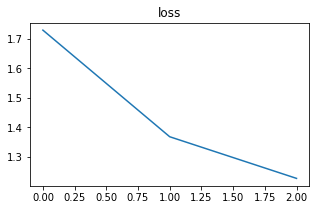

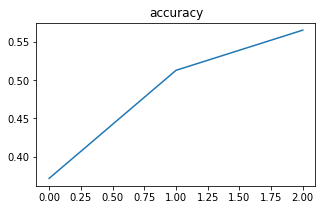

In [7]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 96.53%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). 

In [8]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 7s - loss: 1.1027 - accuracy: 0.6122 - 7s/epoch - 24ms/step
accuracy: 61.22%
CPU times: user 13.5 s, sys: 229 ms, total: 13.7 s
Wall time: 7.55 s


We can also again check the confusion matrix

In [9]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[691  37  33  16  21   3  20   4 125  50]
 [ 28 793   3   2   2   2  17   6  35 112]
 [ 93  17 319  43 167  81 195  37  28  20]
 [ 24  26  48 336 103 122 252  34  17  38]
 [ 41  12  40  43 548  14 226  53  20   3]
 [ 20   9  50 171  98 447 108  61  20  16]
 [  5  13  18  25  25   6 887   5   7   9]
 [ 25   9  22  36  96  59  48 651   9  45]
 [ 96  88   6  10   4   3  17   5 722  49]
 [ 42 140   6   9   5   3  17  13  37 728]]

Classification accuracy for each class:

0: 0.6910
1: 0.7930
2: 0.3190
3: 0.3360
4: 0.5480
5: 0.4470
6: 0.8870
7: 0.6510
8: 0.7220
9: 0.7280


### More verbose training

This approach explicitly handles the looping over data. It will be helpful in future weeks for diving in and optimizing

In [10]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [11]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [12]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [13]:
def train_network(_batch_size, _n_training_epochs, _lr):

    cifar_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, cifar_model, opt)

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 131.7 seconds for epoch #0
beginning epoch 1
took 130.2 seconds for epoch #1
beginning epoch 2
took 130.5 seconds for epoch #2


# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning rate, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.69%, although it varies randomly.

In [15]:
#parameter scan batch_size
for batch_size in (2048,1024,512,256,128):
  epochs = 3
  lr = .01
  history, cnn_model = train_network_concise(batch_size, epochs, lr)
  x_test_reshaped = numpy.expand_dims(x_test, -1)
  scores = cnn_model.evaluate(x_test, y_test, verbose=2)
  print("Batch size",batch_size)
  print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))


Epoch 1/3
25/25 [==============================] - 146s 6s/step - loss: 2.1470 - accuracy: 0.2046
Epoch 2/3
25/25 [==============================] - 142s 6s/step - loss: 1.8315 - accuracy: 0.3343
Epoch 3/3
25/25 [==============================] - 142s 6s/step - loss: 1.6572 - accuracy: 0.4003
313/313 - 11s - loss: 1.4579 - accuracy: 0.4980 - 11s/epoch - 35ms/step
Batch size 2048
accuracy: 49.80%
Epoch 1/3
49/49 [==============================] - 138s 3s/step - loss: 2.0539 - accuracy: 0.2414
Epoch 2/3
49/49 [==============================] - 140s 3s/step - loss: 1.6942 - accuracy: 0.3837
Epoch 3/3
49/49 [==============================] - 139s 3s/step - loss: 1.5295 - accuracy: 0.4458
313/313 - 8s - loss: 1.3451 - accuracy: 0.5245 - 8s/epoch - 26ms/step
Batch size 1024
accuracy: 52.45%
Epoch 1/3
98/98 [==============================] - 141s 1s/step - loss: 1.8237 - accuracy: 0.3343
Epoch 2/3
98/98 [==============================] - 139s 1s/step - loss: 1.4641 - accuracy: 0.4762
Epoch 3/

In [17]:
#parameter scan learning rate
for lr in (1,0.1,0.01,0.001,0.0001):
  batch_size = 256
  epochs = 3
  history, cnn_model = train_network_concise(batch_size, epochs, lr)
  x_test_reshaped = numpy.expand_dims(x_test, -1)
  scores = cnn_model.evaluate(x_test, y_test, verbose=2)
  print("Learning rate",lr)
  print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

Epoch 1/3
196/196 [==============================] - 163s 829ms/step - loss: 1.6853 - accuracy: 0.3853
Epoch 2/3
196/196 [==============================] - 159s 809ms/step - loss: 1.3348 - accuracy: 0.5217
Epoch 3/3
196/196 [==============================] - 155s 789ms/step - loss: 1.1943 - accuracy: 0.5773
313/313 - 8s - loss: 1.0480 - accuracy: 0.6329 - 8s/epoch - 25ms/step
Learning rate 1
accuracy: 63.29%
Epoch 1/3
196/196 [==============================] - 157s 798ms/step - loss: 1.6961 - accuracy: 0.3817
Epoch 2/3
196/196 [==============================] - 154s 785ms/step - loss: 1.3543 - accuracy: 0.5169
Epoch 3/3
196/196 [==============================] - 154s 785ms/step - loss: 1.2169 - accuracy: 0.5684
313/313 - 8s - loss: 1.0494 - accuracy: 0.6372 - 8s/epoch - 26ms/step
Learning rate 0.1
accuracy: 63.72%
Epoch 1/3
196/196 [==============================] - 153s 771ms/step - loss: 1.7423 - accuracy: 0.3652
Epoch 2/3
196/196 [==============================] - 149s 762ms/step - 

In [18]:
#parameter scan epochs
for epochs in (3,6,9,12):
  batch_size = 256
  lr = 0.0001
  history, cnn_model = train_network_concise(batch_size, epochs, lr)
  x_test_reshaped = numpy.expand_dims(x_test, -1)
  scores = cnn_model.evaluate(x_test, y_test, verbose=2)
  print("epochs",epochs)
  print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

Epoch 1/3
196/196 [==============================] - 154s 784ms/step - loss: 1.7406 - accuracy: 0.3666
Epoch 2/3
196/196 [==============================] - 154s 787ms/step - loss: 1.3839 - accuracy: 0.5046
Epoch 3/3
196/196 [==============================] - 155s 790ms/step - loss: 1.2496 - accuracy: 0.5541
313/313 - 8s - loss: 1.0973 - accuracy: 0.6164 - 8s/epoch - 25ms/step
epochs 3
accuracy: 61.64%
Epoch 1/6
196/196 [==============================] - 154s 785ms/step - loss: 1.6953 - accuracy: 0.3818
Epoch 2/6
196/196 [==============================] - 154s 786ms/step - loss: 1.3387 - accuracy: 0.5243
Epoch 3/6
196/196 [==============================] - 155s 791ms/step - loss: 1.1922 - accuracy: 0.5788
Epoch 4/6
196/196 [==============================] - 157s 803ms/step - loss: 1.1197 - accuracy: 0.6035
Epoch 5/6
196/196 [==============================] - 154s 786ms/step - loss: 1.0644 - accuracy: 0.6259
Epoch 6/6
196/196 [==============================] - 153s 783ms/step - loss: 1.0

Lowering batch size improved accuracy but seemed to reach a plateau around a batch size of 256. Lowering learning rate had only a small effect on accuracy. Increasing number of epochs improved accuracy up to close to 70% but seemingly has not yet plateaued. Stopped checking at 12 epochs as it's a slow process.